<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE </span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  Automatic differentiation </font></p>
</p></br>
</p>
</CENTER>

----------------------------

# <span style="color:#00B8DE"> Table of contents</span> 
<a name="table-of-contents"></a>
    
1. [Finite Difference](#Finite-difference)
2. [Improved Finite Difference](#Improved-finite-difference)
3. [Dual Numbers](#Dual-numbers)
4. [Forward Automatic Differentiation](#Forward-automatic-differentiation)
5. [Backward Automatic Differentiation](#Backward-automatic-differentiation)
6. [Exercise: Optimization Problem](#Optimization-problem)
7. [Appendix](#Appendix)
8. [References](#References)

# <span style="color:#00B8DE"> Differentiation:</span>
## <span style="color:#00B8DE"> From finite difference to automatic differentiation</span>

## <span style="color:#00B8DE"> Finite difference </span> 
<a name="Finite-difference"></a> 
[Table of contents](#table-of-contents)

To compute derivatives or partial differentials of a function $f$, one can use finite difference approximation schemes such as $\dfrac{f(x+h)-f(x)}{h}$ or $\dfrac{f(x+h)-f(x-h)}{2h}$, with $h$ small. However, such a scheme lakes precision for high $h$ and suffers from division robustness issue as $h$ decreases. As an example, consider the code below where the function 

$$
f(x)    = x(1-x)(1-2x)^2(1-8x+8x^2)^2e^{1+e^x}
$$ 

is used. Although more precise, symmetric finite difference shows the same behavior as forward finite difference

In [1]:
import Pkg
Pkg.add("SpecialFunctions")
Pkg.add("SymPy")
Pkg.add("DualNumbers") # https://github.com/JuliaDiff/DualNumbers.jl
Pkg.add("ForwardDiff") # https://github.com/JuliaDiff/ForwardDiff.jl
Pkg.add("ReverseDiff") # https://github.com/JuliaDiff/DualNumbers.jl

   Updating registry at `~/.julia/registries/General`
######################################################################### 100,0%
  Resolving package versions...
  Installed ZeroMQ_jll ────── v4.3.2+5
  Installed OpenSpecFun_jll ─ v0.5.3+4
  Installed Zlib_jll ──────── v1.2.11+18
Updating `~/.julia/environments/v1.5/Project.toml`
  [276daf66] + SpecialFunctions v0.10.3
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [efe28fd5] ↑ OpenSpecFun_jll v0.5.3+3 ⇒ v0.5.3+4
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+4 ⇒ v4.3.2+5
  [83775a58] ↑ Zlib_jll v1.2.11+17 ⇒ v1.2.11+18
  Resolving package versions...
  Installed SymPy ─ v1.0.31
Updating `~/.julia/environments/v1.5/Project.toml`
  [24249f21] + SymPy v1.0.31
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [24249f21] + SymPy v1.0.31
  Resolving package versions...
  Installed Calculus ──── v0.5.1
  Installed DualNumbers ─ v0.6.2
Updating `~/.julia/environments/v1.5/Project.toml`
  [fa6b7ba4] + DualNumbers v0.6.2
Updating `~/.julia/env

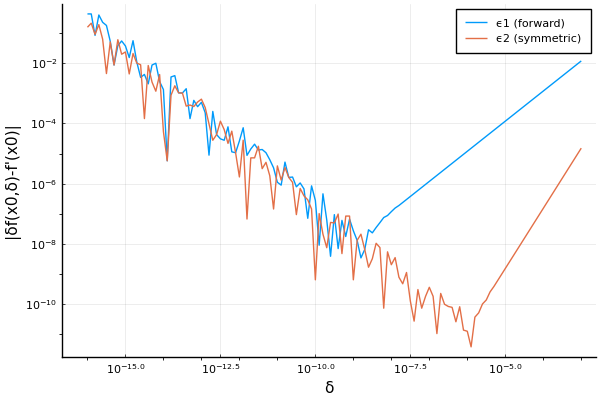

In [10]:
using Plots
pyplot()

f(x)     = x*(1-x)*(1-2x)^2*(1-8x+8x^2)^2*exp(1+exp(x)) 
df(x)    = f(x)*(1/x-1/(1-x)-4/(1-2x)+2*(16x-8)/(1-8x+8x^2)+exp(x))
δf(x,δ)  = (f(x+δ)-f(x))/δ
δf2(x,δ) = (f(x+δ)-f(x-δ))/(2δ)
h        = [1/10^k for k in 16:-.1:3]
x        = 0.3
ϵ1       = [abs(δf(x,δ)-df(x)) for δ in h]
ϵ2       = [abs(δf2(x,δ)-df(x)) for δ in h]

plot(h,ϵ1,xscale=:log10, yscale=:log10,label="ϵ1 (forward)", 
               xlabel="δ",ylabel="|δf(x0,δ)-f'(x0)|")
plot!(h,ϵ2,xscale=:log10, yscale=:log10,label="ϵ2 (symmetric)")

On another hand, the expressions of derivatives generated by symbolic computation software tend to become bulky as the complexity of functions, the number of variables or the order of derivatives increase:

In [14]:
using SymPy

@vars x
df_x = diff(64x*(1-x)*(1-2x)^2*(1-8x+8x^2)^2*exp(1+exp(x)))
df_x

                                                       x                      
              2                     ⎛   2          ⎞  ℯ  + 1                 2
64⋅x⋅(1 - 2⋅x) ⋅(1 - x)⋅(32⋅x - 16)⋅⎝8⋅x  - 8⋅x + 1⎠⋅ℯ       + 64⋅x⋅(1 - 2⋅x) 

                         2      x                                       2   x 
         ⎛   2          ⎞   x  ℯ  + 1                 2 ⎛   2          ⎞   ℯ  
⋅(1 - x)⋅⎝8⋅x  - 8⋅x + 1⎠ ⋅ℯ ⋅ℯ       - 64⋅x⋅(1 - 2⋅x) ⋅⎝8⋅x  - 8⋅x + 1⎠ ⋅ℯ   

                                             2   x                            
+ 1                          ⎛   2          ⎞   ℯ  + 1               2        
    + 64⋅x⋅(1 - x)⋅(8⋅x - 4)⋅⎝8⋅x  - 8⋅x + 1⎠ ⋅ℯ       + 64⋅(1 - 2⋅x) ⋅(1 - x)

                 2   x    
 ⎛   2          ⎞   ℯ  + 1
⋅⎝8⋅x  - 8⋅x + 1⎠ ⋅ℯ      

In [18]:
simplify(factor(df_x))

                                                                              
              ⎛   2          ⎞ ⎛    5  x       4  x        4       3  x       
-64⋅(2⋅x - 1)⋅⎝8⋅x  - 8⋅x + 1⎠⋅⎝16⋅x ⋅ℯ  - 40⋅x ⋅ℯ  + 128⋅x  + 34⋅x ⋅ℯ  - 256⋅

                                            x    
 3       2  x        2      x           ⎞  ℯ  + 1
x  - 11⋅x ⋅ℯ  + 160⋅x  + x⋅ℯ  - 32⋅x + 1⎠⋅ℯ      

## <span style="color:#00B8DE"> Improved finite difference
<a name="Improved-finite-difference"></a> 
[Table of contents](#table-of-contents)

Going back to finite difference method, assume that $f$ admits an analytical extension in the neigbourhood of the real axis and consider the finite difference $Im\left(\dfrac{f(x+ih)-f(x)}{h}\right)$ or $Im\left(\dfrac{f(x+ih)-f(x-ih)}{2h}\right)$, where $Im(.)$ stands for the imaginary part. The following results show a tremendous improvement compared to the finite difference with real valued increment. Do you have any explanation for it? Hint: compare the analytical development of the finite difference in both cases.

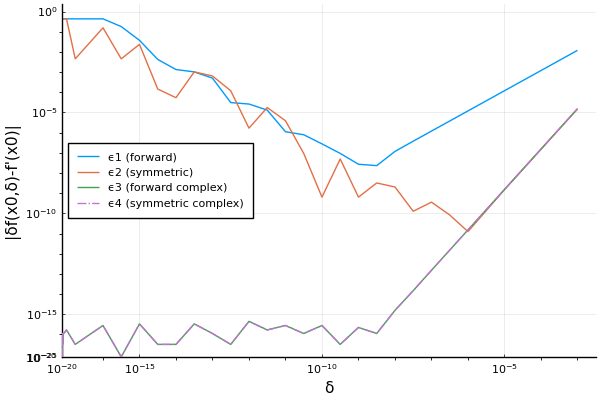

In [26]:
δfi(x,δ)  = imag((f(x+δ*im)-f(x))/δ)
δfi2(x,δ) = imag((f(x+δ*im)-f(x-δ*im))/(2δ))

h       = [1/10^k for k in 20:-.5:3]
x       = 0.3
ϵ1      = [abs(δf(x,δ)-df(x))+1.e-25 for δ in h]
ϵ2      = [abs(δf2(x,δ)-df(x))+1.e-25 for δ in h]
ϵ3      = [abs(δfi(x,δ)-df(x))+1.e-25 for δ in h]
ϵ4      = [abs(δfi2(x,δ)-df(x))+1.e-25 for δ in h]

plot(h,ϵ1,xscale=:log10,yscale=:log10, label="ϵ1 (forward)",
               xlabel="δ",ylabel="|δf(x0,δ)-f'(x0)|")
plot!(h,ϵ2,xscale=:log10, yscale=:log10,label="ϵ2 (symmetric)")
plot!(h,ϵ3,xscale=:log10,yscale=:log10,label="ϵ3 (forward complex)")
plot!(h,ϵ4,xscale=:log10,yscale=:log10,linestyle=:auto,label="ϵ4 (symmetric complex)")

## <span style="color:#00B8DE"> Dual Numbers </span>
<a name="Dual-numbers"></a> 
[Table of contents](#table-of-contents)


Before going to automatic differentiation, let us go beyond the finite difference with complex increment by searching an alternative kind of increment of the variable for which any higher order approximation term will cancel. To this end, we introduce dual numbers [1]. 

First, let us recall that complex numbers $a+jb$ can be introduced in a matrix form $aI+bJ=\begin{bmatrix} a&-b\\ b&a \end{bmatrix}$. The relationship $J^2=-I$ catches the definition $j=\sqrt{-1}$. 

In the same way, dual numbers $a+\varepsilon b$ can be seen has representions of $2\times 2$ matrices $aI+bE=\begin{bmatrix} a&b\\ 0&a \end{bmatrix}$. Note that $E=\begin{bmatrix} 0&1\\ 0&0 \end{bmatrix}$ and $E^2$ is the $2\times 2$ null matrix. in other words, $\varepsilon^2=0$.

Dual numbers are of interest for differentiation. Indeed, il we consider a polynomial $p(x)=\sum_{k=0:n}p_kx^k$, since $(a+\varepsilon b)^k = a^k+k a^{k-1}\varepsilon b$ (because $\varepsilon^m=0$ for $m>1$), we get

$$
p(a+\varepsilon b) = p(a)+\varepsilon b p'(a).
$$

Now, analytic functions write $f(x)=\sum_{k=0:\infty}f^{(k)}(x_0)\dfrac{(x-x_0)^k}{k!}$ and the previous expression extends to 

$$
f(a+\varepsilon b) =\sum_{k=0:\infty}f^{(k)}(a)\dfrac{(\varepsilon b)^k}{k!}= f(a)+\varepsilon b f'(a)
$$

With a view to implement chain rules for derivation based on dual numbers let us consider usual binary operators for dual numbers. Clearly, $(a+\varepsilon b) + (c+\varepsilon d) = (a+c)+\varepsilon (b+d)$ and $(a+\varepsilon b) \times (c+\varepsilon d) = (ac)+\varepsilon (ad+bc)$. For division, assume first that $c\neq 0$:

$$
\dfrac{a+b\varepsilon}{c+d\varepsilon}= \dfrac{(a+b\varepsilon)(c-d\varepsilon)}{(c+d\varepsilon)(c-d\varepsilon)}
= \dfrac{ac-ad\varepsilon+bc\varepsilon}{c^2+cd\varepsilon-cd\varepsilon}
= \dfrac{a}{c} + \dfrac{(bc - ad)}{c^2}\varepsilon
$$

Now, if $c=0$, since ${a+b\varepsilon = (x+y\varepsilon) d\varepsilon} = xd\varepsilon$, there is no solution if $a\neq 0$, while if $a= 0$, $\dfrac{a+b\varepsilon}{c+d\varepsilon}$ can be represented by any dual number in the form $\dfrac{b}{d} + {y\varepsilon}$.

In addition, note that $f(g(a+\varepsilon b))= f(g(a)+\varepsilon g'(b))= f(g(a)) + \varepsilon f'(g(a))g'(b)$.

These results, together with knowledge of the expression of derivatives of usual functions can be used to efficiently implement the derivation chain rule to compute the derivative of complex functions. Here is an example using library **DualNumbers** [3].

In [29]:
using DualNumbers

f(x)  = x*(1-x)*(1-2x)^2*(1-8x+8x^2)^2*exp(1+exp(x)) 
df(x) = f(x)*(1/x-1/(1-x)-4/(1-2x)+2*(16x-8)/(1-8x+8x^2)+exp(x))

x = .3
y = x+ε
δ = 1.e-6 # optimal step size for this function and symmetric difference
print(
"f($y) = $(f(y)) \n
error with dual numbers: $(df(x)-dualpart(f(y))) \n
error on finite difference: $( (f(x+δ)-f(x-δ))/(2δ)-dualpart(f(y)) )" )

f(0.3 + 1.0ɛ) = 0.16288752190025318 + 0.43432091320486865ɛ 

error with dual numbers: 2.220446049250313e-16 

error on finite difference: -1.2470025012589758e-11

Automatic differentiation is intended to provide automated propagation of the chain rules for complex differentiation tasks. 
Several modes can be considered to this end. 

For differentiation tasks **DualNumbers** library [3], that is not maintained currently, has been superseded by **ForwardDiff** library [4] that implements the forward automatic differentiation. Forward differentiation implements the principle of dual numbers calculation: the function evaluations and derivatives are both propagated in the chain rule in a way similar to what is done with dual numbers. 

## <span style="color:#00B8DE"> Forward Automatic Differentiation</span>
<a name="Forward-automatic-differentiation"></a> 
[Table of contents](#table-of-contents)


In [32]:
using ForwardDiff

f(x)  = x*(1-x)*(1-2x)^2*(1-8x+8x^2)^2*exp(1+exp(x)) 
df(x) = f(x)*(1/x-1/(1-x)-4/(1-2x)+2*(16x-8)/(1-8x+8x^2)+exp(x))

x = .3
print("df(x) - ForwardDiff.derivative(f,x) = $( df(x)  - ForwardDiff.derivative(f,x) )")

df(x) - ForwardDiff.derivative(f,x) = 2.220446049250313e-16

Let us consider the example presented in [2]:  $f(x_1,x_2)=x_1\sqrt{\log\dfrac{x_1}{\sin x_2^2}}$. We want to compute the partial derivative 

$$
\dfrac{\partial f}{\partial x_2}=-x_1x_2\cot x_2^2\;\left(\log\dfrac{x_1}{\sin x_2^2}\right)^{-1/2}
$$

We introduce notations for input variables $v_{-1}=x_1$ and $v_{0}=x_0$,intermediate variables $v_1$ to $v_5$ that represent intermediary results provided by elementary operations in the function  definition, and output variable $v_6=f(x_1,x_2)$. Often, as here, indices are set so that the first index of intermediate variables is 1. The flow from $v_{-1:0}=x_{1:2}$ to $v_6=f(x_1,x_2)=y$ is summerized in the following graph.

<center><img src="operations_graph.png" alt="drawing" width="600"/></center>
<center> Graph of operations for function $f(x_1,x_2)$ [1] </center>

These operations can also be represented by the successive operations in the left column in the following table. 

<center><img src="forward_chain_rule.png" alt="drawing" width="500"/></center>
<center> Forward chain rule [1] </center>

The right part of this table represent elementary derivations associated to the elementary operations on the left side. Here setting $\dot{v}_{-1}=0$ and $\dot{v}_0=1$ comes from the fact that we compute partial derivatives w.r.t. $x_2$: $\dot{v}_{-1}=\dfrac{\partial x_1}{\partial x_2}=0$ and $\dot{v}_{0}=\dfrac{\partial x_2}{\partial x_2}=1$. 

In practice, we first propagate calculations through the first column to get the $v_i$s and then through the second one, replacing at each step the right hand side by its numerical value. Finaly, we get 

$$
\begin{array}{ll}
v_{-1:6}&=
[x_1\;\; x_2\;\; \sin x_2^2\;\; \dfrac{x_1}{\sin x_2^2}\;\; \log \dfrac{x_1}{\sin x_2^2}\;\; \sqrt{\log \dfrac{x_1}{\sin x_2^2}} \; \;x_1\sqrt{\log \dfrac{x_1}{\sin x_2^2}}]\\
\\
& = [v_{-1}\;\; v_0\;\; \sin v_0^2\;\; \dfrac{v_{-1}}{v_1}\;\; \log v_2\;\; \sqrt{v_3}\;\; v_{-1}v_4]
\end{array}
$$

where each term $v_i$ is computed recursively from the previous ones $v_{-1:i-1}$. Clearly, the interest is that we don't propagate formulas but only associated numerical values $v_{-1:i-1}$, as classicaly done when we compute the value of a function at a given point.

Then the same principle is used to get the partial derivatives, $\dot{v}_{i}$ being calculated as a function of $v_{-1:i-1}$ and $\dot{v}_{-1:i-1}$:

$$
\begin{array}{ll}
\dot{v}_{-1:6}&=
[0\;\; 1\;\; 2x_2\cos x_2^2\;\; \dfrac{-2x_1x_2\cos x_2^2}{\sin x_2^2}\;\; \ldots]\\
\\
& = [0\;\; 1\;\; 2v_0\dot{v}_0 \;\; (\cos v_1) \dot{v}_1 \;\; \dfrac{\dot{v}_{-1}v_2-v_{-1}\dot{v}_2}{v_2^2} \;\;\ldots]
\end{array}
$$


#### Complete gradient calculation

In [34]:
f(x)   = x[1]*√log(x[1]/sin(x[2]^2))
∇f_1(x) = √log(x[1]/sin(x[2]^2)) + 1/(2*√log(x[1]/sin(x[2]^2)))
∇f_2(x) = -x[1]*x[2]*cot(x[2]^2)*1/√log(x[1]/sin(x[2]^2))

x      = [1,1]
print("ForwardDiff.gradient(f,x)-[∇f_1(x),∇f_2(x)]= $(ForwardDiff.gradient(f,x)-[∇f_1(x),∇f_2(x)])")

ForwardDiff.gradient(f,x)-[∇f_1(x),∇f_2(x)]= [0.0, -4.440892098500626e-16]

#### General chain rule

In a more formal way, the algorithm writes as follows. For $f:\mathbb{R}^n\rightarrow\mathbb{R}$, relationships are in the form $v_i=g_i(v_{s_i})$ with $s_i\subset -n+1:i-1$ and for $i=1:K$ and $y=f(x)=v_K$ . 
$s_i$ is the set of indices of variables that generated $v_i$. Then the forward mode for computing the directional derivative in direction **d** can be implemented as in the following algorithmic form:

1. $v_{-n+1:0}= x_{1:n}$; $\;\dot{v}_{-n+1:0}=$**d**

2. for $i=1:K$

$\quad\quad$ $v_i=g_i(v_{s_i})$

$\quad\quad$ $\dot{v}_i = \sum_{j\in s_i} \dot{v}_j \dfrac{\partial g_i(v_{s_i})}{\partial v_j}$

3. $\dfrac{dy}{dt}(x+t$**d$)=$d** $^T\nabla f(x)=\dot{v}_K$
    
In particular for **d${=}$e**$_i$, the i-th vector of the canonical basis, we get $\dfrac{dy}{dt}(x+t$**e**$_i)=\dfrac{\partial f(x)}{\partial x_i}$.

## <span style="color:#00B8DE"> Backward Automatic Differentiation</span>
<a name="Backward-automatic-differentiation"></a> 
[Table of contents](#table-of-contents)

Note that in the forward automatic differentiation process of the example described above, if we want to compute the partial derivative w.r.t. $x_1$, we must repeat the computations in the second column with $\dot{v}_{-1}=\dfrac{\partial x_1}{\partial x_1}=1$ and $\dot{v}_{0}=\dfrac{\partial x_2}{\partial x_1}=0$. If we consider functions $f:\mathbb{R}^n\rightarrow\mathbb{R}$, the total amount of calculations to get the gradient of $f$ increases linearly with $n$. However, being able to compute gradients at lower cost would be of high interest for optimization purpose.

The backward mode adresses this kind of issue. It involves variables $\overline{v}_i=\dfrac{\partial f}{\partial v_i}$ and is closely related to backpropagation techniques developped for learning neural networks. $\overline{v}_i$ represents the sensibility of the output to variations of intermediate variables. 

To make the reverse mode clearer, consider first a simple case where $f:\mathbb{R}\rightarrow\mathbb{R}$ and $f$ is a composition of one to one transforms: $f(x)=g_n\circ g_{n-1}\circ\ldots \circ g_1(x)$, that is $v_0=x$ and $v_i=g_i(v_{i-1})$ for $i=1:n$. The graph of $f$ is made of a simple line and the derivation chain rule yields

$$
\begin{array}{ll}
\overline{v}_{i-1}
&=\dfrac{\partial y}{\partial v_{i-1}}=\dfrac{\partial}{\partial v_{i-1}}g_n\circ g_{n-1}\circ ...\circ g_{i}(v_{i-1}) \\
\\
&= \dfrac{\partial }{\partial v_i} g_n\circ g_{n-1}\circ ...\circ g_{i+1}(v_{i})
\times \dfrac{\partial g_{i}(v_{i-1})}{\partial v_{i-1}}\\
\\
&= \dfrac{\partial y}{\partial v_i}\times\dfrac{\partial v_i}{\partial v_{i-1}} = \overline{v}_{i}\dfrac{\partial v_i}{\partial v_{i-1}}
\end{array}
$$

More generally, if $f:\mathbb{R}^n\rightarrow\mathbb{R}$, relationships are in the form $v_i=g_i(v_{s_i})$ with $s_i\subset -n+1:i-1$. 
$s_i$ is the set of indices of variables that generated $v_i$ while $\{j;i\in s_j\}$ represents the set of next indices in the graph when going from $v_i$ to $y$.

$$
\overline{v}_i =\dfrac{\partial y}{\partial v_i}=\sum_{\{j;i\in s_j\}}\dfrac{\partial y}{\partial v_j}\dfrac{\partial g_j(v_{s_j})}{\partial v_i}= \sum_{\{j;i\in s_j\}} \overline{v}_j\dfrac{\partial v_j}{\partial v_i}
$$

The graph of the example that we considered in forward differentiation section is quite complex due in particular to multiple occurences of the variable $x_1$ in the definition and the presence of binary operators.
Initially, variables $\overline{v}_i$ are set to 0. Then, the sensitivities are propagated backward until obtaining the entries of $\nabla f$, here $\overline{v}_{-1}= \dfrac{\partial f}{\partial x_1}$ and $\overline{v}_{0}=\dfrac{\partial f}{\partial x_2}$. Unlike with the forward mode, we see here that the second column is swept only once to obtain the gradient at a given point. 

Here, the computation of $f(x_1,x_2)$ is done from top to bottom for the left hand side, like for the forward mode, while operations on the right hand side are performed from the bottom to the top. 

In particular, we see that at the 4th line of the second column of the table for reverse mode, $\overline{v}_{-1}$ is added to itself. This comes from the fact that in the graph of operations $y$ is influenced by ${v}_{-1}$ through the direct path but also through the path passing by $v_3$. 
<!-- To explain further the relationships in the right column, note that 
$$
\overline{v}_i =\dfrac{\partial y}{\partial v_i}=\sum_{j\in ch(i)}\dfrac{\partial y}{\partial v_j}\dfrac{\partial v_j}{\partial v_i}= \sum_{j\in ch (i)}\overline{v}_j\dfrac{\partial v_j}{\partial v_i}
$$
where $ch (i)$ is the set of children $\{v_j\}$ of $v_i$ in the graph oriented from entries ${x_k}$ to output $y$. In particular, for $i=-1$, $ch(i)=\{3,6\}$ and two terms contribute to the caculation of $\overline{v}_{-1}$ -->

<center><img src="operations_graph.png" alt="drawing" width="600"/></center>
<center> Graph of operations for function $f(x_1,x_2)$ [1] </center>


<center><img src="backward_chain_rule.png" alt="drawing" width="400"/></center>
<center> Backward chain rule [1] </center>


The reverse mode can be implemented as in the following algorithmic form where $y=v_K$:

1. $v_{-n+1:0}=x_{1:n}$

2. for j= 1:K 

$\quad\quad$ $v_i=g_i(v_{s_i})$

3. $\overline{v}_K=1$, $\overline{v}_{-n+1:K-1}=0$

4. for $j=K-1:-1:1$

$\quad\quad$ for $i\in s_j$ 

$\quad\quad\quad$ $\dfrac{\partial v_j}{\partial v_i}=\dfrac{\partial g_j(v_{s_j})}{\partial v_i}$

$\quad\quad\quad$ $\overline{v}_i = \overline{v}_i + \overline{v}_j\dfrac{\partial v_j}{\partial v_i}$
    
You can find other examples illustrating the reverse mode in [5], [6] or [7] (p.13) for instance.

For functions $f:\mathbb{R}^n\rightarrow\mathbb{R}^m$ where the input dimension is higher than the output dimension ($n>m$), it is generally more efficient to use the reverse mode while the forward mode is recommended when $m>n$. In fact, forward and reverse modes computational complexity are about $n×ops(f)$ and $m×ops(f)$ operations respectively, where $ops(f)$ is the number of operations required to compute $f$. It is also possible to combine both modes.

Concerning libraries **ForwardDiff.jl** [4] and **ReverseDiff.jl** [9-10], it is added in [9] that ReverseDiff generally performs better for gradients when $n>100$ or when $n$ is larger than the number of operations performed to compute $f$. ReverseDiff is also recommanded for functions involving array-based operations.

Let us compute the gradients 

In [ ]:
using ForwardDiff, ReverseDiff

f(x)    = x[1]*√log(x[1]/sin(x[2]^2))
∇f_1(x) = √log(x[1]/sin(x[2]^2)) + 1/(2*√log(x[1]/sin(x[2]^2)))
∇f_2(x) = -x[1]*x[2]*cot(x[2]^2)*1/√log(x[1]/sin(x[2]^2))

x      = [1.,1.]
@time println("ForwardDiff.gradient error: $(ForwardDiff.gradient(f,x)-[∇f_1(x),∇f_2(x)])")
@time println("ReverseDiff.gradient error: $(ReverseDiff.gradient(f,x)-[∇f_1(x),∇f_2(x)])") # note : woud not work with x=[1,1]

## <span style="color:#00B8DE"> Exercise: an Optimization Problem</span>
<a name="Optimization-problem"></a> 
[Table of contents](#table-of-contents)

Consider the function $f({\bf x})=\dfrac{\parallel {\bf x}\parallel^4}{1+\parallel{\bf x}\parallel^2}$

> - Plot the function
> - Implement gradient and Newton algorithm with backtracking using forward differentiation to compute the gradient an the Hessian
> - Plot the current error at each loop for both algorithms (choose for instance ${\bf x}\in\mathbb{R}^{10}$)

In [ ]:
...

In [ ]:
...

------

# <span style="color:#00B8DE"> Appendix</span>
<a name="Appendix"></a> 
[Table of contents](#table-of-contents)


## <span style="color:#00B8DE">A - Simple dual number algebra implementation</span>

see also https://www.youtube.com/watch?v=vAp6nUMrKYg

In [ ]:
# Dual structure and associated operators

struct Dual_ <: Number # class of dual numbers 
    d::Tuple{Float64,Float64}
end

import Base: +, -, *, /, convert, promote_rule, show

+(x::Dual_,y::Dual_) = Dual_(x.d .+ y.d)
-(x::Dual_,y::Dual_) = Dual_(x.d .- y.d)
-(x::Dual_)          = Dual_((-x.d[1],-x.d[2]))
*(x::Dual_,y::Dual_) = Dual_((x.d[1]*y.d[1], x.d[2]*y.d[1]+x.d[1]*y.d[2]))
/(x::Dual_,y::Dual_) = Dual_((x.d[1]/y.d[1], (x.d[2]*y.d[1]-x.d[1]*y.d[2])/y.d[1]^2))

ϵ                   = Dual_((0,1))
realPart(x::Dual_)  = x.d[1]
dualPart(x::Dual_)  = x.d[2]
conj(x::Dual_)      = Dual_((x.d[1],-x.d[2]))

convert(::Type{Dual_},x::Real) = Dual_((x,zero(x)))
promote_rule(::Type{Dual_},::Type{<:Number}) = Dual_
show(io::IO,x::Dual_)= x.d[2]>=0 ? print(io,x.d[1],"+ϵ",x.d[2]) : print(io,x.d[1],"-ϵ",abs(x.d[2]))

In [ ]:
x=Dual_((1,2))
y=Dual_((3,4))
x+y, x/y, Dual_((1.,0))==1., Dual_((1,-2)), Dual_((0,0))^2

In [ ]:
# let us redefine a few clasic functions from basic operators

#cos_(x) = sum([(-x^2)^k/factorial(2k) for k=0:10])     # Poor definition !
#sin_(x) = sum([x*(-x^2)^k/factorial(2k+1) for k=0:9])

exp_(x;n=20) = 1 + sum( accumulate((u,v)->x*u/v, 1:n, init=1) )
cos_(x;n=20) = 1 + sum( accumulate((u,v)-> -x^2*u/(2v*(2v-1)), 1:n, init=1) )
sin_(x;n=20) = x + sum( accumulate((u,v)-> -x^2*u/(2v*(2v+1)), 1:n, init=x) )

print(exp_(1)-exp(1),'\n',cos_(π/4)-√2/2,'\n', sin_(π/4)-√2/2)

function root_(x,k::Int;n=10)
    t=1
    for _=1:n
        t += (x/t^(k-1)-t)/k
    end
    t
end

In [ ]:
root_(1+ϵ,5)

In [ ]:
using Plots
pyplot()

x = range(0,stop=10,length=100)
y = [sin_(rem(u,2π)+ϵ) for u in x]

p1 = plot(x,realPart.(y),label="sin_")
p2 = plot(x,dualPart.(y),label="sin_'")
plot(p1,p2)#,layout=(1,1))
x = range(0,stop=10,length=20)
scatter!(x,[sin.(x),cos.(x)],label="")

## <span style="color:#00B8DE">B - An example for a large problem </span>


Let us consider a somewhat complex example from https://github.com/JuliaDiff/ReverseDiff.jl/blob/master/examples/gradient.jl that enables optimized operations, that can be useful/necessary for big problems. See the doc of  ReverseDiff for more information

In [38]:
# Code from https://github.com/JuliaDiff/ReverseDiff.jl/blob/master/examples/gradient.jl
################
using ReverseDiff: GradientTape, GradientConfig, gradient, gradient!, compile, DiffResults

#########
# setup #
#########

# some objective function to work with
f(a, b) = sum(a' * b + a * b')

# pre-record a GradientTape for `f` using inputs of shape 100x100 with Float64 elements
const f_tape = GradientTape(f, (rand(100, 100), rand(100, 100)))

# compile `f_tape` into a more optimized representation
const compiled_f_tape = compile(f_tape)

# some inputs and work buffers to play around with
a, b = rand(100, 100), rand(100, 100)
inputs = (a, b)
results = (similar(a), similar(b))
all_results = map(DiffResults.GradientResult, results)
cfg = GradientConfig(inputs)

####################
# taking gradients #
####################

# with pre-recorded/compiled tapes (generated in the setup above) #
#-----------------------------------------------------------------#

# this should be the fastest method, and non-allocating
gradient!(results, compiled_f_tape, inputs)

# the same as the above, but in addition to calculating the gradients, the value `f(a, b)`
# is loaded into the the provided `DiffResult` instances (see DiffResults.jl documentation).
gradient!(all_results, compiled_f_tape, inputs)

# this should be the second fastest method, and also non-allocating
gradient!(results, f_tape, inputs)

# you can also make your own function if you want to abstract away the tape
∇f!(results, inputs) = gradient!(results, compiled_f_tape, inputs)

# with a pre-allocated GradientConfig #
#-------------------------------------#
# these methods are more flexible than a pre-recorded tape, but can be
# wasteful since the tape will be re-recorded for every call.

gradient!(results, f, inputs, cfg)

gradient(f, inputs, cfg)

# without a pre-allocated GradientConfig #
#----------------------------------------#
# convenient, but pretty wasteful since it has to allocate the GradientConfig itself

gradient!(results, f, inputs)

gradient(f, inputs)

([95.15001684876657 92.6767134811275 … 94.4146061509646 98.68007823884541; 94.8795615103044 92.40625814266534 … 94.14415081250243 98.40962290038324; … ; 95.10267440673721 92.62937103909815 … 94.36726370893524 98.63273579681605; 97.76499416734758 95.2916907997085 … 97.02958346954561 101.29505555742642], [94.94333567849267 100.17912776670433 … 95.3015478682614 100.88947817254314; 95.26415672315574 100.49994881136739 … 95.62236891292446 101.2102992172062; … ; 91.43230251314628 96.66809460135795 … 91.79051470291502 97.37844500719675; 96.0656637054263 101.30145579363796 … 96.42387589519504 102.01180619947677])

-----------
# <span style="color:#00B8DE"> References</span>
<a name="References"></a> 
[Table of contents](#table-of-contents)

>- [1] https://en.wikipedia.org/wiki/Dual_number
>- [2] https://www.sanyamkapoor.com/machine-learning/autograd-magic/
>- [3] https://github.com/JuliaDiff/DualNumbers.jl
>- [4] http://www.juliadiff.org/ForwardDiff.jl/stable/index.html
>- [5] https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation
>- [6] http://www.columbia.edu/~ahd2125/post/2015/12/5/ 
>- [7] https://arxiv.org/pdf/1502.05767.pdf#page31
>- [8] https://www.youtube.com/watch?v=xtfNug-htcs
>- [9] https://github.com/JuliaDiff/ReverseDiff.jl
>- [10] http://www.juliadiff.org/ReverseDiff.jl/api/
